In [ ]:
# Step 1. swig 설치 (Box2D용)
!apt-get install -y swig

# Step 2. gymnasium[box2d]와 box2d-py 설치
!pip install "gymnasium[box2d]" box2d-py

# 드라이브 마운트 (필요한 경우)
from google.colab import drive
drive.mount('/content/drive')


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (1,177 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 126101 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubu

In [ ]:
# # 기존 box2d-py 완전히 삭제
# !pip uninstall box2d-py -y

# # 올바른 Box2D 설치 (gymnasium 공식 Box2D 지원)
# !pip install gymnasium[box2d]

# # 설치 후 바로 정상 작동 여부 체크
# import gymnasium as gym
# env = gym.make("CarRacing-v2", continuous=False, render_mode="rgb_array")
# state, info = env.reset()
# print("환경 초기 상태 shape:", state.shape)


In [ ]:
# # swig 설치
# !apt-get install -y swig

# # pip, setuptools, wheel 업그레이드
# !pip install --upgrade pip setuptools wheel

# # box2d-py 설치
# !pip install box2d-py


In [ ]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib
from IPython.display import HTML
import sys
sys.path.append('/content/drive/MyDrive/src5')


import torch
import torch.nn as nn
import torch.nn.functional as F

from CNN import CNNActionValue
from evaluate import evaluate
import DQN as DQN
from Preprocess import preprocess, ImageEnv

In [ ]:
env = gym.make('CarRacing-v3', continuous=False)
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

Observation space:  Box(0, 255, (96, 96, 3), uint8)
Action space:  Discrete(5)


(96, 96, 3)


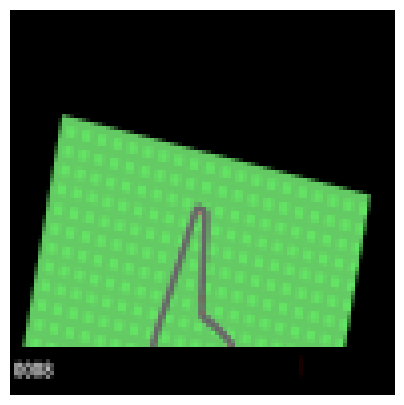

In [ ]:
s, info = env.reset()
print(s.shape)

frames = []
for i in range(50):
    s, r, terminated, truncated, info = env.step(0)  # 0-th action is no_op action
    frames.append(s)

# Create animation
fig = plt.figure(figsize=(5, 5))
plt.axis('off')
im = plt.imshow(frames[0])
def animate(i):
    im.set_array(frames[i])
    return im,
anim = FuncAnimation(fig, animate, frames=len(frames))
HTML(anim.to_jshtml())

The shape of an observation:  (4, 84, 84)


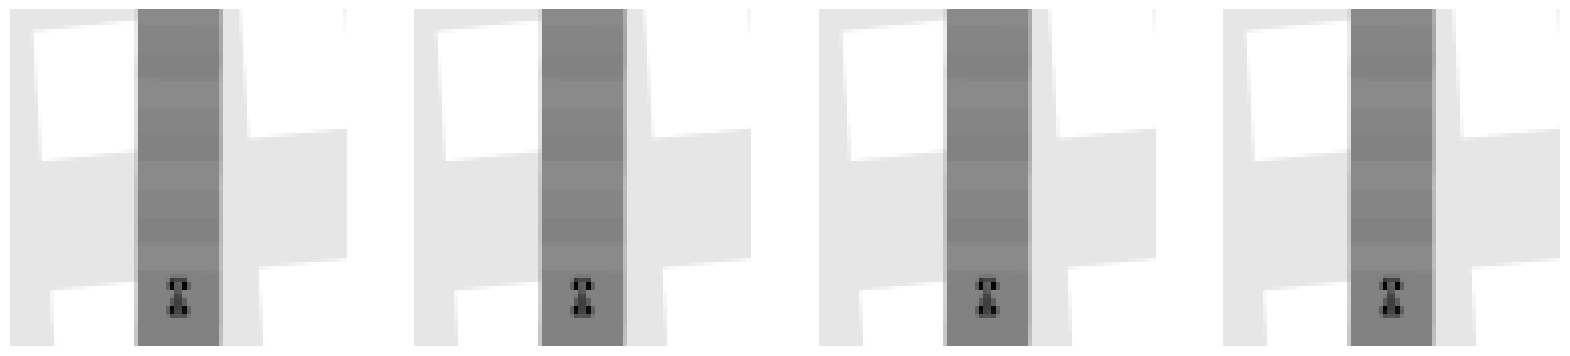

In [ ]:
env = gym.make('CarRacing-v3', continuous=False)
env = ImageEnv(env)

s, _ = env.reset()
print("The shape of an observation: ", s.shape)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

In [ ]:
env = gym.make('CarRacing-v3', continuous=False)
env = ImageEnv(env)

max_steps = int(1e5)
eval_interval = 100
state_dim = (4, 84, 84)
action_dim = env.action_space.n

agent = DQN.DQN(state_dim, action_dim)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
def evaluate(n_evals=5):
    eval_env = gym.make('CarRacing-v3', continuous=False)
    eval_env = ImageEnv(eval_env)

    scores = 0
    for i in range(n_evals):
        (s, _), done, ret = eval_env.reset(), False, 0
        while not done:
            a = agent.act(s, training=False)
            s_prime, r, terminated, truncated, info = eval_env.step(a)
            s = s_prime
            ret += r
            done = terminated or truncated
        scores += ret
    return np.round(scores / n_evals, 4)

In [ ]:
from IPython.display import clear_output
from evaluate import evaluate


history = {'Step': [], 'AvgReturn': []}

(s, _) = env.reset()
while True:
    a = agent.act(s)
    s_prime, r, terminated, truncated, info = env.step(a)
    result = agent.process((s, a, r, s_prime, terminated))  # You can track q-losses over training from `result` variable.

    s = s_prime
    if terminated or truncated:
        s, _ = env.reset()

    if agent.total_steps % eval_interval == 0:
        ret = evaluate(agent)
        history['Step'].append(agent.total_steps)
        history['AvgReturn'].append(ret)

        clear_output()
        plt.figure(figsize=(8, 5))
        plt.plot(history['Step'], history['AvgReturn'], 'r-')
        plt.xlabel('Step', fontsize=16)
        plt.ylabel('AvgReturn', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(axis='y')
        plt.show()

        torch.save(agent.network.state_dict(), 'dqn.pt')

    if agent.total_steps > max_steps:
        break

In [ ]:
eval_env = gym.make('CarRacing-v3', continuous=False, render_mode='rgb_array')
eval_env = ImageEnv(eval_env)

frames = []
scores = 0
(s, _), done, ret = eval_env.reset(), False, 0
while not done:
    frames.append(eval_env.render())
    a = agent.act(s, training=False)
    s_prime, r, terminated, truncated, info = eval_env.step(a)
    s = s_prime
    ret += r
    done = terminated or truncated
scores += ret

In [ ]:
import matplotlib.animation as animation
fig = plt.figure()
ims = []

for frame in frames:
    im = plt.imshow(frame, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)

import os

# 1. 저장할 폴더 설정 (src 폴더)
save_folder = 'src5'
os.makedirs(save_folder, exist_ok=True)  # 폴더 없으면 생성

# 2. 저장 경로 설정
save_path = os.path.join(save_folder, 'result05.gif')

# 3. 기존 ani.save() 수정
ani.save(save_path, writer='pillow')

print(f"GIF가 저장된 경로: {save_path}")
